In [1]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

### Mount drive and load datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Base_path ='/content/drive/MyDrive/Data/RS2'

#### Raw Recipes

In [5]:
raw_recipies = pd.read_csv(Base_path+"/RAW_recipes.csv")

In [6]:
raw_recipies.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [7]:
raw_recipies=raw_recipies[['name', 'id']]

In [8]:
raw_recipies.head()

,name,id
0,arriba baked winter squash mexican style,137739
1,a bit different breakfast pizza,31490
2,all in the kitchen chili,112140
3,alouette potatoes,59389
4,amish tomato ketchup for canning,44061


In [9]:
raw_recipies.rename(columns = {'id':'recipe_id'}, inplace = True)

#### Rating

In [10]:
ratings=pd.read_csv(Base_path+"/interactions_train.csv")

In [11]:
ratings.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [12]:
# Number of users
print('The ratings dataset has', ratings['user_id'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['recipe_id'].nunique(), 'unique recipe')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 25076 unique users
The ratings dataset has 160901 unique recipe
The ratings dataset has 6 unique ratings
The unique ratings are [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


In [13]:
recipe_rating=ratings

In [14]:
recipe_rating=recipe_rating.drop(['date','u','i'], axis=1)

In [15]:
# Merge ratings and movies datasets
df = pd.merge(recipe_rating, raw_recipies, on='recipe_id', how='inner')

# Take a look at the data
df.head()

,user_id,recipe_id,rating,name
0,2046,4684,5.0,flank steak with lime chipotle sauce
1,12882,4684,5.0,flank steak with lime chipotle sauce
2,37758,4684,5.0,flank steak with lime chipotle sauce
3,37636,4684,5.0,flank steak with lime chipotle sauce
4,54697,4684,5.0,flank steak with lime chipotle sauce


#### Aggregate Dataframe of recipes with more than 50 rating

In [16]:
# Aggregate by recipe
agg_ratings = df.groupby('name').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the recipe with more than 50 ratings
agg_ratings= agg_ratings[agg_ratings['number_of_ratings']>50]

# Check the information of the dataframe
agg_ratings.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 39 to 159940
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1160 non-null   object 
 1   mean_rating        1160 non-null   float64
 2   number_of_ratings  1160 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 36.2+ KB


In [17]:
# Check popular recipes
agg_ratings.sort_values(by='number_of_ratings', ascending=False).head()

,name,mean_rating,number_of_ratings
147889,to die for crock pot roast,4.413382,1091
45104,crock pot chicken with black beans cream cheese,4.346977,1075
155875,whatever floats your boat brownies,4.608696,897
42779,creamy cajun chicken pasta,4.691275,894
81650,kittencal s italian melt in your mouth meatballs,4.777637,787


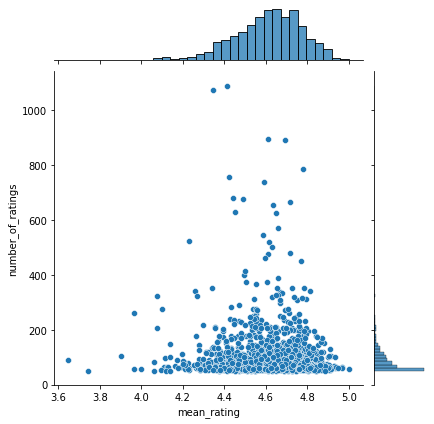

In [19]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings)

In [20]:
# Merge data
df = pd.merge(df, agg_ratings[['name']], on='name', how='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128756 entries, 0 to 128755
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    128756 non-null  int64  
 1   recipe_id  128756 non-null  int64  
 2   rating     128756 non-null  float64
 3   name       128756 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 4.9+ MB


In [21]:
# Number of users
print('The ratings dataset has', df['user_id'].nunique(), 'unique users')

# Number of recipes
print('The ratings dataset has', df['recipe_id'].nunique(), 'unique recipes')

# Number of ratings
print('The ratings dataset has', df['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df['rating'].unique()))

The ratings dataset has 20188 unique users
The ratings dataset has 1191 unique recipes
The ratings dataset has 6 unique ratings
The unique ratings are [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


In [28]:
# Create user-item matrix
df=df.groupby(['user_id','recipe_id'])['rating'].max().unstack()

In [29]:
# Decompose the user-item ratings matrix using SVD
U, sigma, Vt = svds(df, k=50)
sigma = np.diag(sigma)

In [30]:
# Predict the ratings for all users and items
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [31]:
predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
# Define the number of recommended items
num_recommendations = 5

# Calculate the item-item similarity matrix using cosine similarity
item_similarities = cosine_similarity(predicted_ratings.T)

In [ ]:
# Recommend top items based on similarity for each user
top_items = np.zeros((predicted_ratings.shape[0], num_recommendations))
for i in range(predicted_ratings.shape[0]):
    top_items[i] = np.argsort(-item_similarities[i])[:num_recommendations]